<h1> SIFT implementation from scratch </h1>

# Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from scipy.spatial.distance import cdist

# Funtion to show image

In [2]:
def show_image(img, title="", cmap=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

> Showing Original image and image to be matched

--2025-04-27 09:31:18--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50728 (50K) [image/png]
Saving to: ‘test_image.png’

test_image.png      100%[===================>]  49.54K  --.-KB/s    in 0.05s   

2025-04-27 09:31:18 (954 KB/s) - ‘test_image.png’ saved [50728/50728]

Downloading...
From: https://drive.google.com/uc?id=15xg1mafHxzTobSsWK8FPj6hk-Ef-TmrB
To: /content/match.png
100% 83.1k/83.1k [00:00<00:00, 102MB/s]


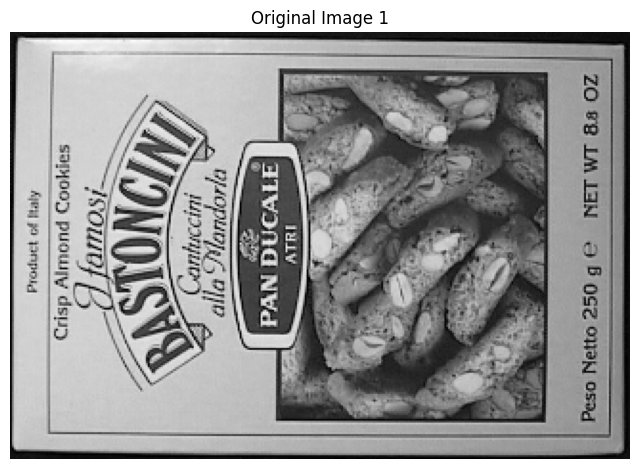

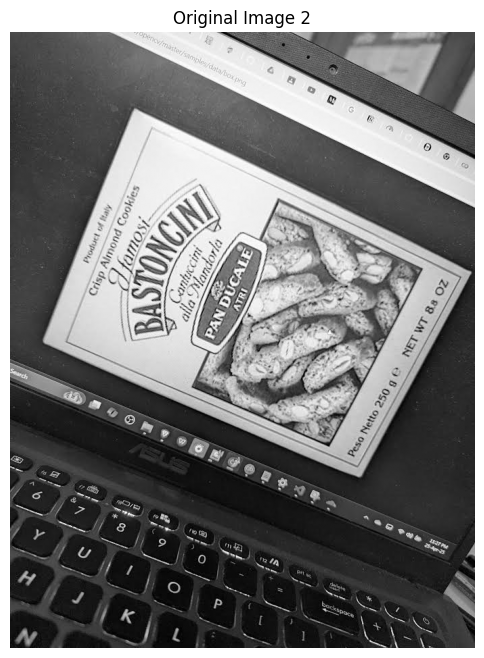

In [3]:
# Load images
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png -O test_image.png
!gdown 15xg1mafHxzTobSsWK8FPj6hk-Ef-TmrB -O match.png

img1 = cv2.imread('test_image.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
img2 = cv2.imread('match.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)

show_image(img1, "Original Image 1", cmap='gray')
show_image(img2, "Original Image 2", cmap='gray')

# Scale Space

>This function `generate_octaves` is responsible for constructing the Gaussian scale-space required for the SIFT algorithm. It takes an input image and progressively generates multiple octaves, each containing a series of increasingly blurred images at different scales. Within each octave, the function applies Gaussian blurring using a calculated sigma value to simulate different levels of image detail. For higher octaves, the first image is a downsampled version (by a factor of 2) of a specific image from the previous octave. This progressive blurring and resizing helps in detecting keypoints that are scale-invariant, allowing SIFT to recognize features regardless of image size or resolution.

In [4]:
def generate_octaves(img, num_octaves, scales_per_octave, sigma):
    octaves = []
    k = 2 ** (1.0 / scales_per_octave)

    for octave in range(num_octaves):
        octave_images = []
        for scale in range(scales_per_octave + 3):  # +3 for DoG
            if octave == 0 and scale == 0:
                octave_images.append(img)
            elif scale == 0:
                # Downsample previous octave's image by factor of 2
                prev_octave = octaves[octave-1]
                octave_images.append(cv2.resize(prev_octave[scales_per_octave],
                                               (0,0), fx=0.5, fy=0.5))
            else:
                prev_img = octave_images[scale-1]
                sigma_total = sigma * (k ** scale - k ** (scale-1))
                octave_images.append(filters.gaussian_filter(prev_img, sigma_total))
        octaves.append(octave_images)

    return octaves

> Generating and showing scale space for both images

In [5]:
num_octaves = 4
scales_per_octave = 3
initial_sigma = 1.6

octaves1 = generate_octaves(img1, num_octaves, scales_per_octave, initial_sigma)
octaves2 = generate_octaves(img2, num_octaves, scales_per_octave, initial_sigma)

<ipython-input-4-8ca92737462e>:18: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  octave_images.append(filters.gaussian_filter(prev_img, sigma_total))


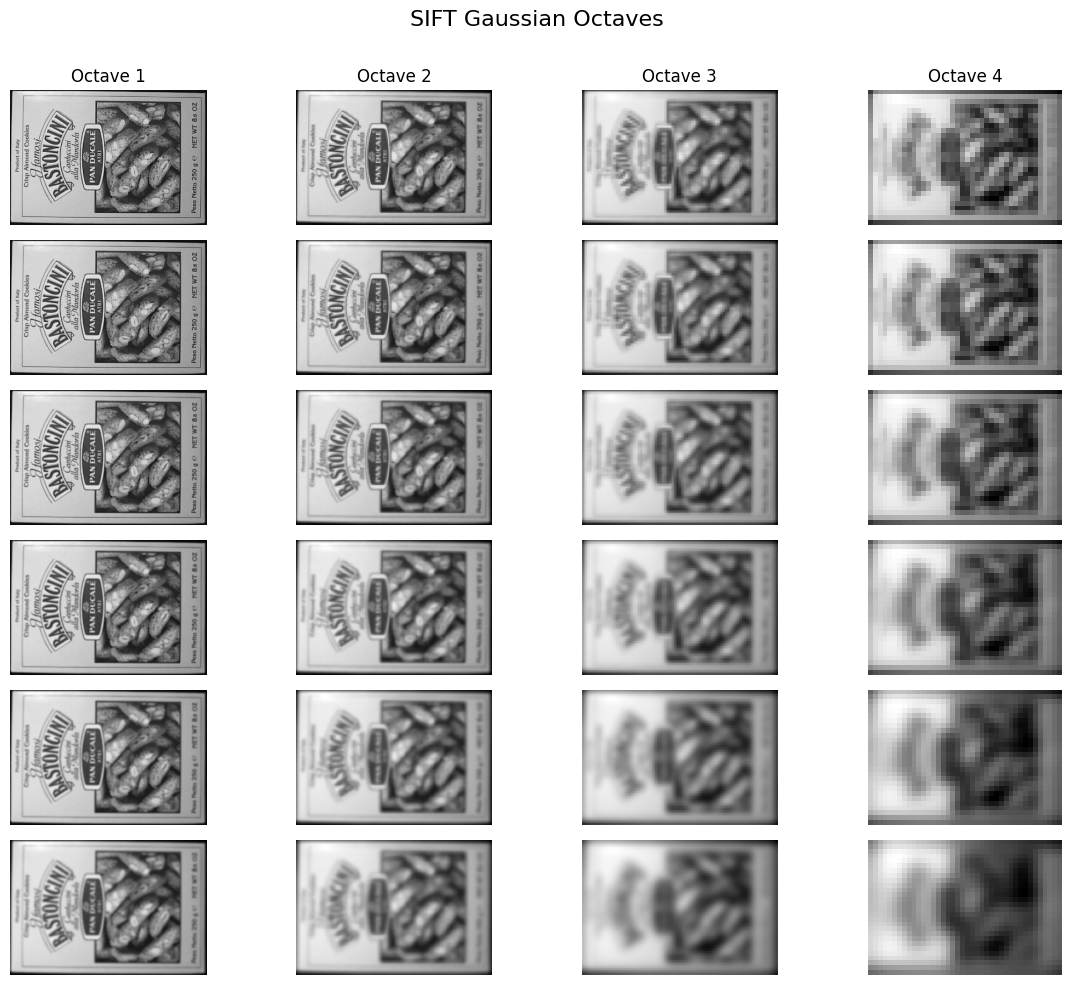

In [6]:
fig, axs = plt.subplots(len(octaves1[0]), num_octaves, figsize=(12, 10))
fig.suptitle("SIFT Gaussian Octaves", fontsize=16)

for col in range(num_octaves):
    for row in range(len(octaves1[col])):
        axs[row, col].imshow(octaves1[col][row], cmap='gray')
        axs[row, col].axis('off')
        if row == 0:
            axs[row, col].set_title(f"Octave {col + 1}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Difference of Gaussian (DoG)

The `generate_dog` function is designed to create the Difference of Gaussian (DoG) images for each octave. The DoG is crucial for detecting keypoints in the SIFT algorithm, as it highlights regions in the image where there is a significant change in intensity, making it easier to identify distinctive features. The function works by iterating through each octave, taking the difference between consecutive Gaussian-blurred images within that octave. This difference highlights edges and blobs that are useful for keypoint detection. The resulting DoG images are stored in separate lists for each octave, which are then returned for further processing.

In [7]:
def generate_dog(octaves):
    dog_octaves = []
    for octave in octaves:
        dog_images = []
        for i in range(1, len(octave)):
            dog_images.append(octave[i] - octave[i-1])
        dog_octaves.append(dog_images)
    return dog_octaves

> Generating and Displaying DoG

In [8]:
dog_octaves1 = generate_dog(octaves1)
dog_octaves2 = generate_dog(octaves2)

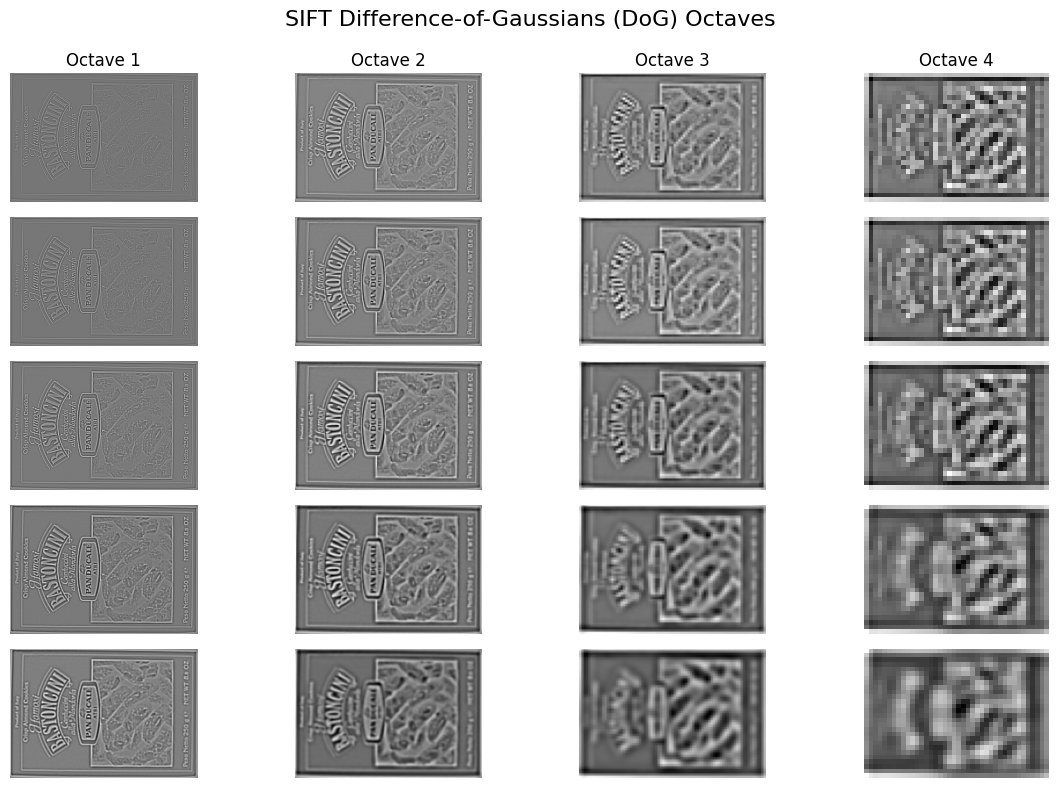

In [9]:
num_octaves = len(dog_octaves1)
scales_per_octave = len(dog_octaves1[0])

fig, axs = plt.subplots(scales_per_octave, num_octaves, figsize=(12, 8))
fig.suptitle("SIFT Difference-of-Gaussians (DoG) Octaves", fontsize=16)

for col in range(num_octaves):
    for row in range(scales_per_octave):
        axs[row, col].imshow(dog_octaves1[col][row], cmap='gray')
        axs[row, col].axis('off')
        if row == 0:
            axs[row, col].set_title(f"Octave {col + 1}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Keypoints

The `find_keypoints` function identifies stable and distinctive keypoints in the Difference of Gaussian (DoG) images by analyzing a 3x3x3 neighborhood around each pixel across multiple scales. It first applies a contrast threshold to discard weak keypoints, then checks for local extrema (maxima or minima) to detect potential keypoints. Edge rejection is performed by evaluating the curvature of the pixel's surrounding area using the Hessian matrix. Finally, keypoints are sorted by magnitude and the top ones are selected. This process ensures that only reliable and robust keypoints are retained for further tasks like matching or object recognition.

In [10]:
def find_keypoints(dog_octaves, contrast_threshold=0.04, edge_threshold=10, max_keypoints=800):
    keypoints = []
    threshold = np.floor(0.5 * contrast_threshold / len(dog_octaves[0]) * 255)

    for octave_idx, dog_octave in enumerate(dog_octaves):
        for scale_idx in range(1, len(dog_octave)-1):
            img = dog_octave[scale_idx]
            img_prev = dog_octave[scale_idx-1]
            img_next = dog_octave[scale_idx+1]

            for i in range(1, img.shape[0]-1):
                for j in range(1, img.shape[1]-1):
                    # 3x3x3 neighborhood check
                    patch = np.stack([
                        img_prev[i-1:i+2, j-1:j+2],
                        img[i-1:i+2, j-1:j+2],
                        img_next[i-1:i+2, j-1:j+2]
                    ])

                    center = patch[1, 1, 1]
                    abs_center = abs(center)
                    if abs_center < threshold:
                        continue

                    is_extremum = False
                    if center > 0 and center == np.max(patch):
                        is_extremum = True
                    elif center < 0 and center == np.min(patch):
                        is_extremum = True

                    if is_extremum:
                        # Edge rejection
                        dxx = img[i, j+1] + img[i, j-1] - 2*img[i, j]
                        dyy = img[i+1, j] + img[i-1, j] - 2*img[i, j]
                        dxy = (img[i+1, j+1] - img[i+1, j-1] - img[i-1, j+1] + img[i-1, j-1]) / 4.0

                        tr = dxx + dyy
                        det = dxx * dyy - dxy**2

                        if det > 0:  # Only valid if det > 0
                            curvature = tr**2 / det
                            if curvature < (edge_threshold + 1)**2 / edge_threshold:
                                # Store with magnitude information
                                keypoints.append({
                                    'octave': octave_idx,
                                    'scale': scale_idx,
                                    'y': i,
                                    'x': j,
                                    'magnitude': abs_center,
                                    'response': center
                                })

    # Sort by magnitude and select top keypoints
    keypoints.sort(key=lambda k: k['magnitude'], reverse=True)
    return keypoints[:max_keypoints]

> Determine and display keypoints
> (A lot of keypoints have been taken otherwise fewer matches were found)

In [11]:
# Get improved keypoints
keypoints1 = find_keypoints(dog_octaves1, max_keypoints=10000)
keypoints2 = find_keypoints(dog_octaves2, max_keypoints=10000)

The `draw_keypoints` function visualizes keypoints on a given image, with enhanced display features like dynamic color mapping and sizing based on keypoint properties. The function first filters keypoints belonging to the specified octave index and then calculates normalized magnitudes and response values for color enhancement. Each keypoint is drawn as a circle with a dynamic radius based on its magnitude, and its color intensity is determined by its response and magnitude. The function also visualizes the keypoint's orientation (if available) as a line extending from the keypoint's center. This results in a clearer, more visually informative representation of keypoints, which is especially useful for tasks like object recognition or matching.

In [12]:
def draw_keypoints(img, keypoints, octave_idx=0):
    img_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    octave_kps = [kp for kp in keypoints if kp['octave'] == octave_idx]
    if not octave_kps:
        return img_display

    # Get normalization factors
    magnitudes = np.array([kp['magnitude'] for kp in octave_kps])
    responses = np.array([abs(kp['response']) for kp in octave_kps])

    # Enhanced color mapping parameters
    mag_norms = ((magnitudes - magnitudes.min()) / (magnitudes.max() - magnitudes.min() + 1e-6)) ** 0.6
    resp_norms = ((responses - responses.min()) / (responses.max() - responses.min() + 1e-6)) ** 0.4

    for idx, kp in enumerate(octave_kps):
        scale_factor = 2 ** kp['octave']
        x = int(kp['x'] * scale_factor)
        y = int(kp['y'] * scale_factor)

        # Vibrant color mapping (hot colormap)
        color = (
            int(255 * (1 - resp_norms[idx]**3)),  # Deep reds
            int(255 * mag_norms[idx]**0.6),      # Bright greens
            0                                   # No blue
        )

        # Dynamic sizing (3-12px)
        radius = int(3 + 9 * mag_norms[idx])

        # Crisp 1px outline with enhanced color
        cv2.circle(img_display, (x, y), radius, color, 1, lineType=cv2.LINE_AA)

        # Orientation indicator (same color)
        if 'orientation' in kp:
            line_length = radius * 1.3
            x2 = int(x + line_length * np.cos(np.deg2rad(kp['orientation'])))
            y2 = int(y + line_length * np.sin(np.deg2rad(kp['orientation'])))
            cv2.line(img_display, (x, y), (x2, y2), color, 1, lineType=cv2.LINE_AA)

    return img_display

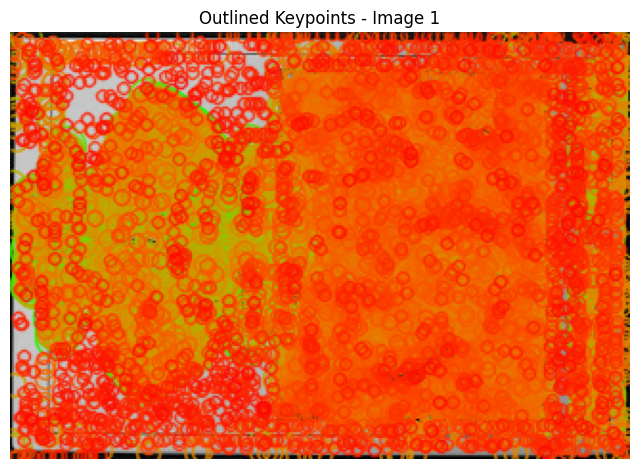

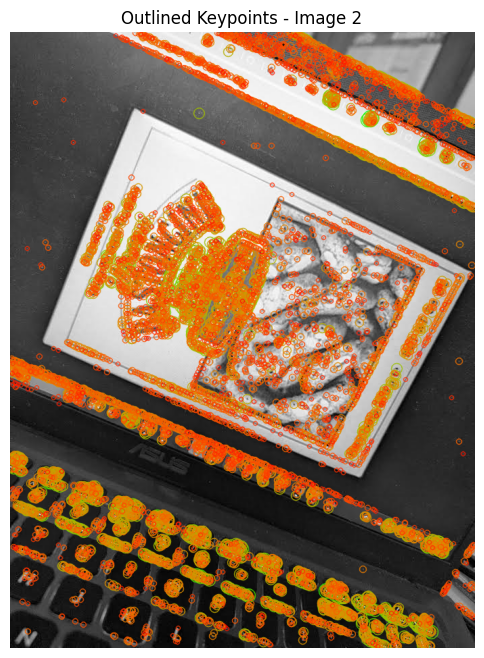

In [13]:
# Visualize with crisp outlines
img1_kp = draw_keypoints(img1, keypoints1)
img2_kp = draw_keypoints(img2, keypoints2)

show_image(img1_kp, "Outlined Keypoints - Image 1")
show_image(img2_kp, "Outlined Keypoints - Image 2")

# Orientation

The `assign_orientations` function assigns orientations to keypoints based on local image gradients, which is a crucial step for making keypoints invariant to rotation. The process begins by calculating the gradient magnitudes and orientations using Sobel filters, followed by creating a histogram of gradient orientations for each keypoint's neighborhood. The function uses a Gaussian weighting scheme to give higher importance to gradients closer to the keypoint. After constructing the histogram, the main orientation is determined as the peak of the histogram, and this is assigned to the keypoint. If there are any additional orientations that are 80% of the maximum value in the histogram, they are also assigned to the keypoint, creating multiple orientations for the same keypoint if necessary. The output is a list of keypoints, each associated with one or more orientations, ensuring that the keypoints are invariant to rotations in the image.

In [14]:
def assign_orientations(img, keypoints, num_bins=36, radius=3, sigma=1.5):
    oriented_keypoints = []

    # Compute gradients
    gaussian = filters.gaussian_filter(img, sigma)
    dx = filters.sobel(gaussian, 1)  # x gradient
    dy = filters.sobel(gaussian, 0)  # y gradient
    mag = np.sqrt(dx**2 + dy**2)
    ori = np.arctan2(dy, dx) * 180 / np.pi  # in degrees

    for kp in keypoints:
        # Handle both tuple and dict keypoint formats
        if isinstance(kp, dict):
            octave, scale, y, x = kp['octave'], kp['scale'], kp['y'], kp['x']
        else:  # tuple format
            octave, scale, y, x = kp[:4]

        scale_factor = 2 ** octave
        x_scaled = int(x * scale_factor)
        y_scaled = int(y * scale_factor)

        # Get neighborhood
        x_min = max(0, x_scaled - radius)
        x_max = min(img.shape[1], x_scaled + radius + 1)
        y_min = max(0, y_scaled - radius)
        y_max = min(img.shape[0], y_scaled + radius + 1)

        # Create orientation histogram
        hist = np.zeros(num_bins)
        bin_width = 360 / num_bins

        for i in range(y_min, y_max):
            for j in range(x_min, x_max):
                # Weight by gradient magnitude and Gaussian
                weight = mag[i, j] * np.exp(-((j-x_scaled)**2 + (i-y_scaled)**2) / (2 * (1.5 * sigma)**2))
                bin_idx = int((ori[i, j] % 360) / bin_width)
                hist[bin_idx] += weight

        # Find peaks in histogram
        max_bin = np.argmax(hist)
        max_val = hist[max_bin]

        # Get main orientation
        main_ori = (max_bin + 0.5) * bin_width

        # Create keypoint with orientation
        if isinstance(kp, dict):
            new_kp = kp.copy()
            new_kp['orientation'] = main_ori
            oriented_keypoints.append(new_kp)
        else:
            oriented_keypoints.append((*kp[:4], main_ori))

        # Check for additional orientations (80% of max)
        for bin_idx in range(num_bins):
            if bin_idx != max_bin and hist[bin_idx] >= 0.8 * max_val:
                additional_ori = (bin_idx + 0.5) * bin_width
                if isinstance(kp, dict):
                    new_kp = kp.copy()
                    new_kp['orientation'] = additional_ori
                    oriented_keypoints.append(new_kp)
                else:
                    oriented_keypoints.append((*kp[:4], additional_ori))

    return oriented_keypoints

The `plot_orientation_histogram_grid` function visualizes keypoint orientations in an image by displaying both the keypoint location and its corresponding orientation histogram. For each keypoint, the image is shown with the keypoint marked, and a histogram of gradient orientations within a local neighborhood is plotted next to it. The main orientation is highlighted with a red dashed line. This allows for an intuitive understanding of the keypoint's orientation and its surrounding gradients, helping to analyze the robustness and consistency of detected features across different keypoints.

In [15]:
import seaborn as sns
sns.set(style='whitegrid')

def plot_orientation_histogram_grid(img, keypoints, num_samples=9, cols=3):
    import math

    gaussian = filters.gaussian_filter(img, 1.5)
    dx = filters.sobel(gaussian, 1)
    dy = filters.sobel(gaussian, 0)
    ori = np.arctan2(dy, dx) * 180 / np.pi

    rows = math.ceil(num_samples / cols)
    fig, axs = plt.subplots(rows, cols * 2, figsize=(6 * cols, 4 * rows))
    axs = axs.reshape(rows, cols * 2)

    sample_kps = keypoints[:num_samples]

    for idx, kp in enumerate(sample_kps):
        row = idx // cols
        col_img = (idx % cols) * 2
        col_hist = col_img + 1

        if isinstance(kp, dict):
            octave, scale, y, x, angle = kp['octave'], kp['scale'], kp['y'], kp['x'], kp.get('orientation', 0)
        else:
            octave, scale, y, x, angle = *kp[:4], kp[4] if len(kp) > 4 else 0

        scale_factor = 2 ** octave
        x_scaled = int(x * scale_factor)
        y_scaled = int(y * scale_factor)

        radius = 3
        x_min = max(0, x_scaled - radius)
        x_max = min(img.shape[1], x_scaled + radius + 1)
        y_min = max(0, y_scaled - radius)
        y_max = min(img.shape[0], y_scaled + radius + 1)

        hist, bins = np.histogram(ori[y_min:y_max, x_min:x_max].flatten() % 360,
                                  bins=36, range=(0, 360))

        # Show full image with keypoint
        axs[row, col_img].imshow(img, cmap='gray')
        axs[row, col_img].scatter([x_scaled], [y_scaled], c='red', s=50, edgecolors='black')
        axs[row, col_img].set_title(f"Keypoint {idx+1}", fontsize=12)
        axs[row, col_img].axis('off')

        # Orientation histogram
        axs[row, col_hist].bar(bins[:-1], hist, width=10, color='skyblue', edgecolor='gray')
        axs[row, col_hist].axvline(x=angle, color='red', linestyle='--', label=f'{angle:.1f}°')
        axs[row, col_hist].set_title(f"Orientation Histogram (Main: {angle:.1f}°)", fontsize=11)
        axs[row, col_hist].set_xlabel("Degrees", fontsize=9)
        axs[row, col_hist].set_ylabel("Magnitude", fontsize=9)
        axs[row, col_hist].legend(fontsize=8)
        axs[row, col_hist].set_xlim(0, 360)
        axs[row, col_hist].set_xticks(range(0, 361, 90))

    # Hide empty axes if num_samples < rows * cols
    total_cells = rows * cols
    for idx in range(len(sample_kps), total_cells):
        row = idx // cols
        col_img = (idx % cols) * 2
        col_hist = col_img + 1
        axs[row, col_img].axis('off')
        axs[row, col_hist].axis('off')

    plt.tight_layout()
    plt.show()


<ipython-input-14-b832390230bf>:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  gaussian = filters.gaussian_filter(img, sigma)
<ipython-input-14-b832390230bf>:6: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = filters.sobel(gaussian, 1)  # x gradient
<ipython-input-14-b832390230bf>:7: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = filters.sobel(gaussian, 0)  # y gradient
<ipython-input-15-ec569e20806a>:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  gaussian = filters.gaussian_f

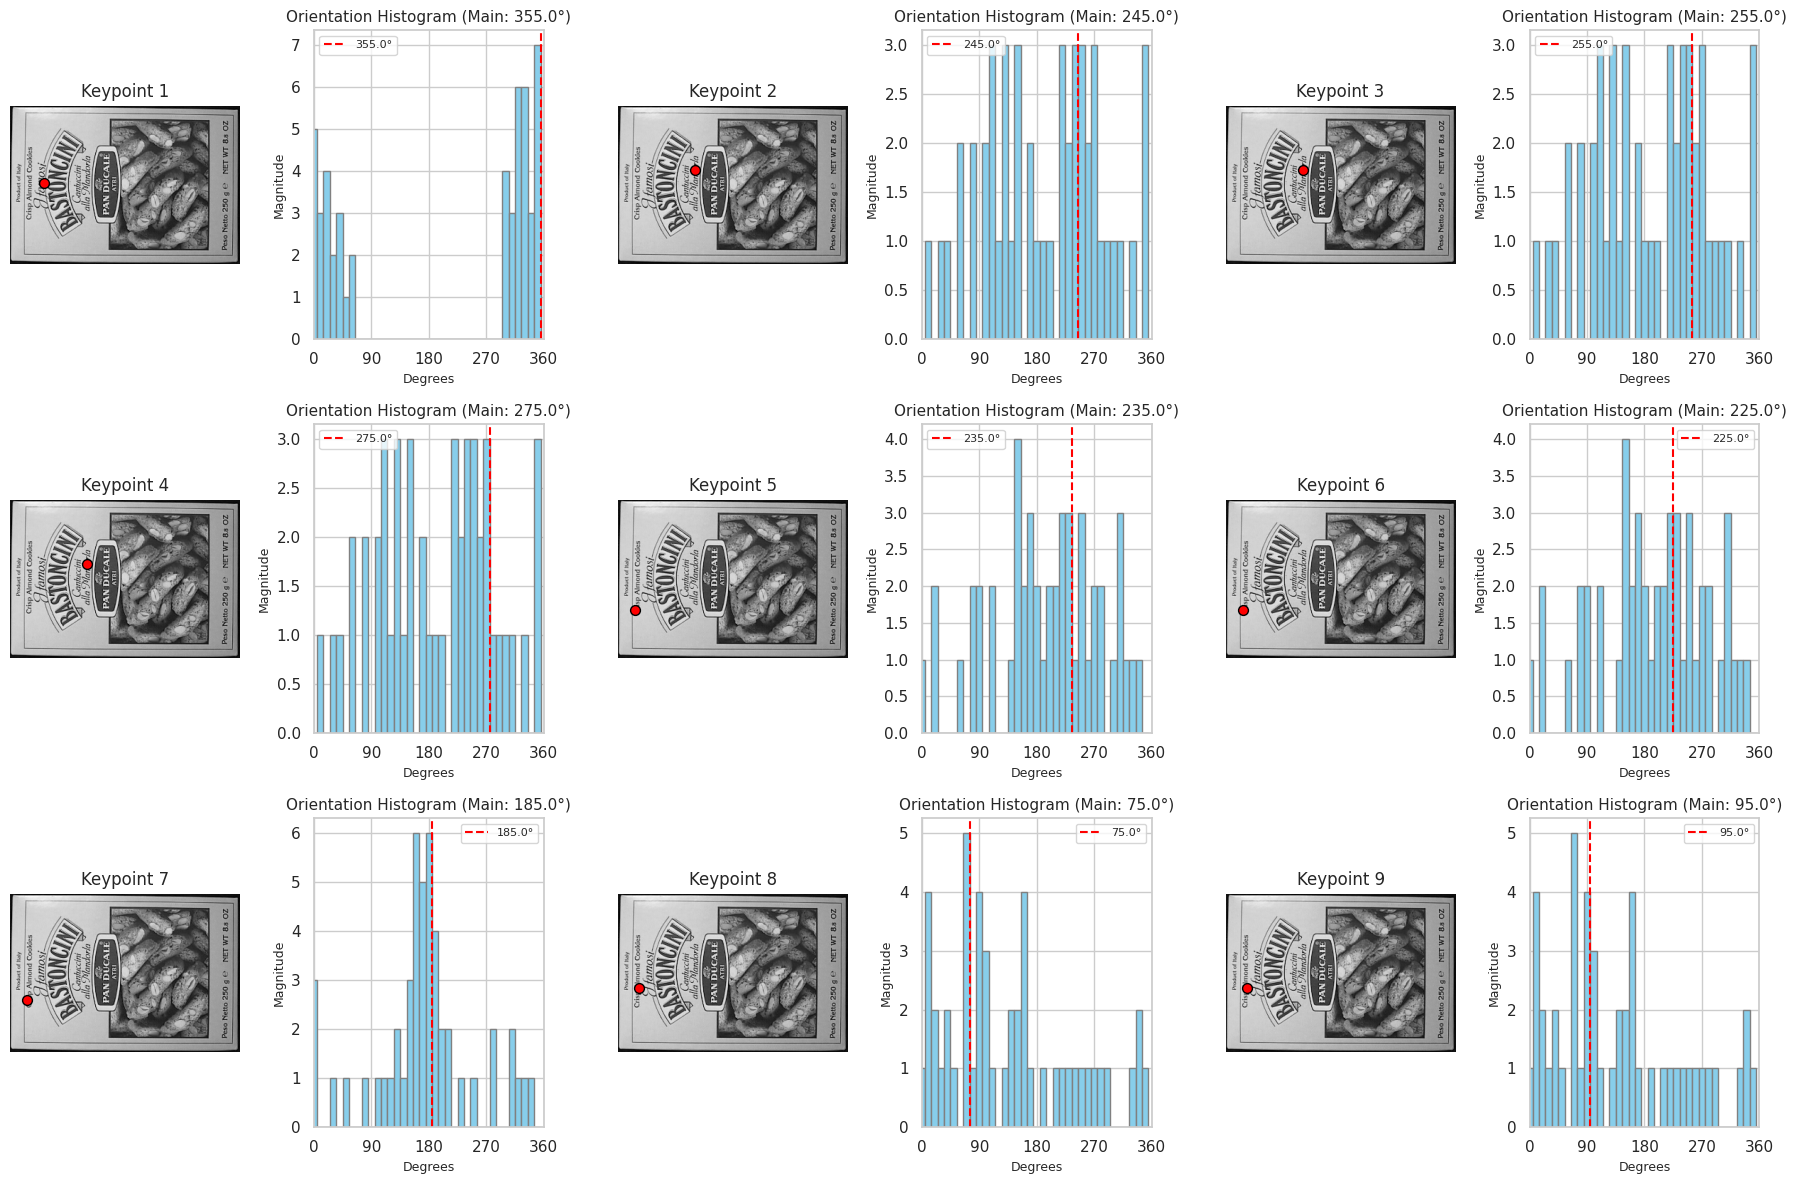

In [16]:
oriented_kp1 = assign_orientations(img1, keypoints1)
oriented_kp2 = assign_orientations(img2, keypoints2)

plot_orientation_histogram_grid(img1, oriented_kp1)
#plot_orientation_histogram(img2, oriented_kp2)

# Descriptors

The `generate_descriptors` function calculates the SIFT descriptors for oriented keypoints in an image. It first computes the gradient magnitude and orientation using Sobel filters, followed by rotating the image according to each keypoint's orientation. For each keypoint, the surrounding 16x16 pixel region is divided into 16 subregions (4x4 grid), and histograms of gradient orientations (with 8 bins) are computed for each subregion. The gradients are weighted by their magnitude and a Gaussian window to ensure that the descriptor is more sensitive to nearby pixels. The resulting descriptors are then normalized, clipped to limit large values, and renormalized to provide stable and consistent feature representations. These descriptors are crucial for matching keypoints across different images in tasks like object recognition and image stitching.

In [17]:
def generate_descriptors(img, oriented_keypoints, num_subregions=4, num_bins=8, descriptor_size=128):
    descriptors = []

    # Compute image gradients
    gaussian = filters.gaussian_filter(img, 1.5)
    dx = filters.sobel(gaussian, 1)  # x gradient
    dy = filters.sobel(gaussian, 0)  # y gradient
    mag = np.sqrt(dx**2 + dy**2)     # gradient magnitude
    ori = np.arctan2(dy, dx) * 180 / np.pi  # orientation in degrees

    for kp in oriented_keypoints:
        # Handle both tuple and dict keypoint formats
        if isinstance(kp, dict):
            octave = kp['octave']
            y = kp['y']
            x = kp['x']
            angle = kp.get('orientation', 0)
        else:
            octave, _, y, x, angle = kp[:5]  # We don't need scale here

        scale_factor = 2 ** octave
        x_scaled = int(x * scale_factor)
        y_scaled = int(y * scale_factor)

        # Precompute rotation terms
        cos_angle = np.cos(np.deg2rad(-angle))
        sin_angle = np.sin(np.deg2rad(-angle))

        # Initialize descriptor (4x4 subregions, each with 8 orientation bins)
        descriptor = np.zeros((num_subregions, num_subregions, num_bins))
        region_size = num_subregions * 4  # 16x16 pixel region (4x4 subregions of 4x4 pixels)

        # Examine 16x16 pixel region around keypoint
        for i in range(-region_size//2, region_size//2):
            for j in range(-region_size//2, region_size//2):
                # Rotate coordinates relative to keypoint orientation
                x_rot = j * cos_angle - i * sin_angle
                y_rot = j * sin_angle + i * cos_angle

                # Original image coordinates
                x_img = x_scaled + j
                y_img = y_scaled + i

                if 0 <= x_img < img.shape[1] and 0 <= y_img < img.shape[0]:
                    # Determine which subregion this pixel belongs to
                    subregion_x = int((x_rot + region_size//2) / (region_size/num_subregions))
                    subregion_y = int((y_rot + region_size//2) / (region_size/num_subregions))

                    if 0 <= subregion_x < num_subregions and 0 <= subregion_y < num_subregions:
                        # Calculate relative orientation (0-360°)
                        rel_ori = (ori[y_img, x_img] - angle) % 360
                        bin_idx = int(rel_ori / (360 / num_bins))

                        # Weight contribution by magnitude and Gaussian window
                        weight = mag[y_img, x_img] * np.exp(-(j**2 + i**2) / (2 * (0.5 * region_size)**2))
                        descriptor[subregion_y, subregion_x, bin_idx] += weight

        # Normalize descriptor
        descriptor = descriptor.flatten()
        descriptor /= np.linalg.norm(descriptor)
        descriptor = np.clip(descriptor, 0, 0.2)  # Limit large values
        descriptor /= np.linalg.norm(descriptor)  # Renormalize

        descriptors.append(descriptor)

    return descriptors

The `visualize_descriptor` function is used to display the distribution of orientations within each subregion of a SIFT descriptor. It takes a descriptor (a flattened array) and reshapes it into a 4x4 grid of subregions, each containing 8 orientation bins. For each subregion, a bar plot is generated to show the magnitude of gradient orientations in each of the 8 bins. The x-axis represents the orientation bins (with labels corresponding to angles), and the y-axis represents the weight (magnitude) of each orientation. This visualization helps to understand the distribution of gradient orientations around a keypoint and provides insight into the keypoint's local appearance. The function is useful for visually inspecting the robustness and consistency of the descriptors across different regions of the image.

In [18]:
def visualize_descriptor(descriptor, num_subregions=4, num_bins=8):
    descriptor = descriptor.reshape((num_subregions, num_subregions, num_bins))

    fig, axes = plt.subplots(num_subregions, num_subregions, figsize=(12, 12))
    plt.suptitle("SIFT Descriptor (4×4 subregions × 8 orientations)", y=1.02)

    for i in range(num_subregions):
        for j in range(num_subregions):
            axes[i,j].bar(range(num_bins), descriptor[i,j], width=0.8)
            axes[i,j].set_xticks(np.arange(num_bins))
            axes[i,j].set_xticklabels([f"{int(x*45)}°" for x in range(num_bins)])
            axes[i,j].set_ylim(0, 0.2)
            axes[i,j].set_title(f"Region {i},{j}", pad=2)

    plt.tight_layout()
    plt.show()

<ipython-input-17-3eaeaa3a0c31>:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  gaussian = filters.gaussian_filter(img, 1.5)
<ipython-input-17-3eaeaa3a0c31>:6: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = filters.sobel(gaussian, 1)  # x gradient
<ipython-input-17-3eaeaa3a0c31>:7: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = filters.sobel(gaussian, 0)  # y gradient


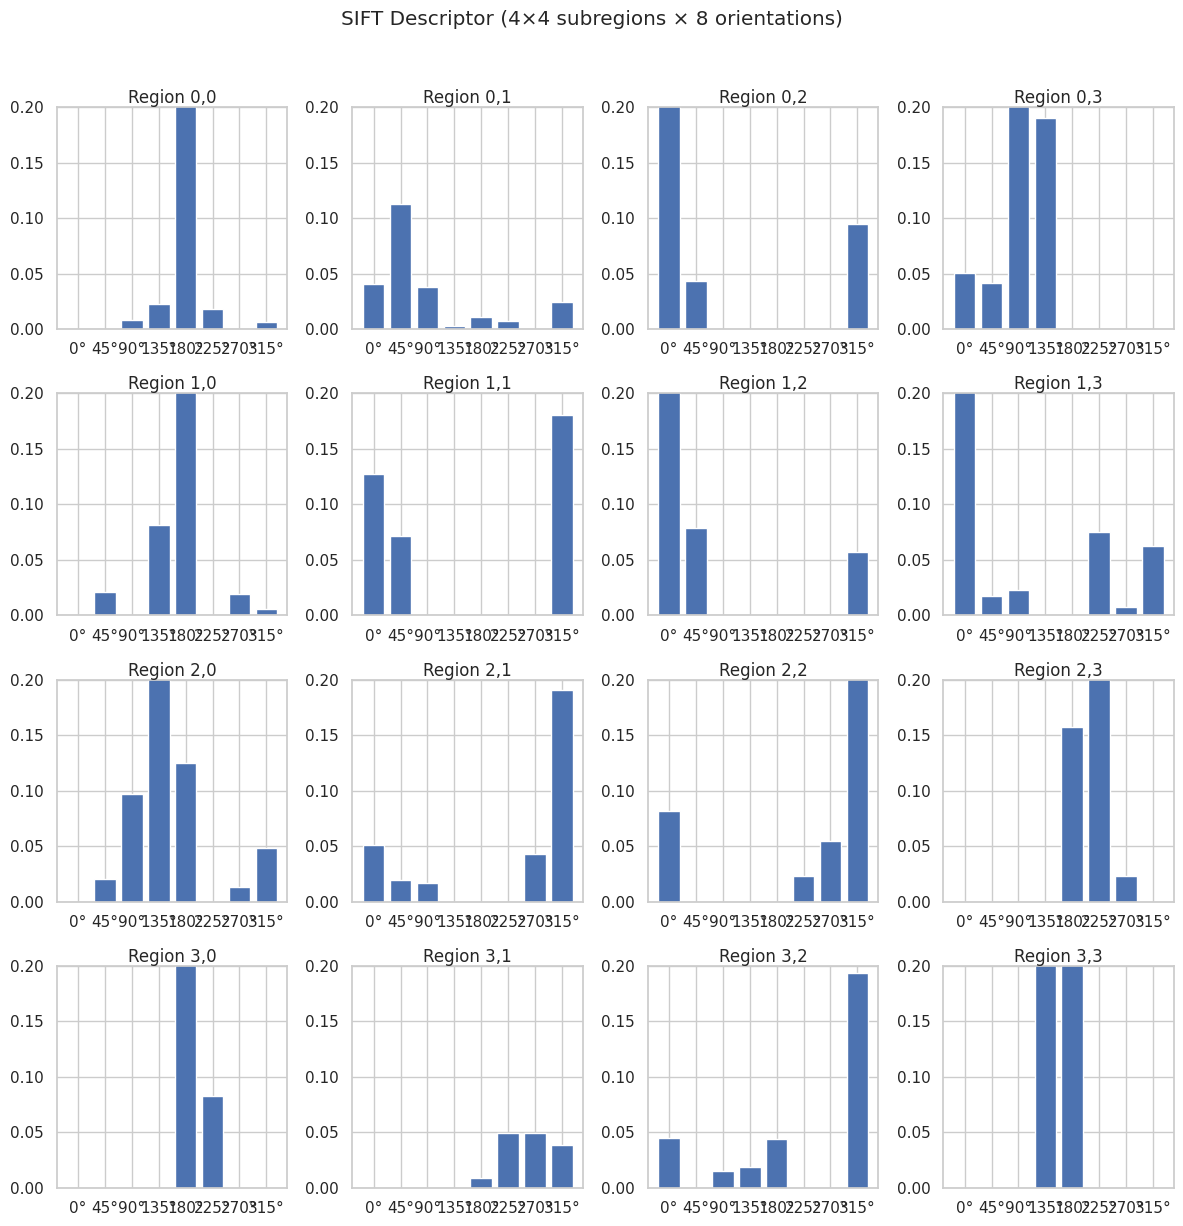

In [19]:
descriptors1 = generate_descriptors(img1, oriented_kp1)
descriptors2 = generate_descriptors(img2, oriented_kp2)

visualize_descriptor(descriptors1[0])

# Feature matching

The `match_features` function matches keypoints between two images based on their SIFT descriptors. The process involves computing the pairwise Euclidean distance between descriptors from two images. For each descriptor in the first image, the function identifies the two closest descriptors in the second image and applies Lowe's ratio test, which ensures that the best match is significantly closer than the second-best match. The result is a list of matches that pass this test, sorted by distance.


In [20]:
def match_features(descriptors1, descriptors2, threshold=0.75):
    matches = []

    if len(descriptors1) == 0 or len(descriptors2) == 0:
        return matches

    # Compute pairwise distances
    dists = cdist(descriptors1, descriptors2, 'euclidean')

    for i in range(len(descriptors1)):
        # Find two nearest neighbors
        sorted_indices = np.argsort(dists[i])
        best_idx = sorted_indices[0]
        second_best_idx = sorted_indices[1]

        # Lowe's ratio test
        if dists[i, best_idx] < threshold * dists[i, second_best_idx]:
            matches.append({
                'queryIdx': i,
                'trainIdx': best_idx,
                'distance': dists[i, best_idx],
                'ratio': dists[i, best_idx] / dists[i, second_best_idx]
            })

    # Sort matches by distance (best matches first)
    matches.sort(key=lambda m: m['distance'])
    return matches


The `draw_matches` function visualizes the matches between two images. It creates a combined image by concatenating the two input images side by side and then draws lines between the matching keypoints. It also places small red circles at the keypoints to highlight their locations. The function optionally limits the number of matches shown, displaying only the top matches according to their distance. The matches are drawn in green, and the final image is displayed with a title indicating how many matches were found.


In [21]:
def draw_matches(img1, kp1, img2, kp2, matches, max_matches=800,threshold=0.8):
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    result = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    result[:h1, :w1] = img1
    result[:h2, w1:w1+w2] = img2
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

    # Show only top matches if there are too many
    matches = matches[:max_matches]

    for match in matches:
        idx1 = match['queryIdx']
        idx2 = match['trainIdx']

        # Handle both tuple and dict keypoint formats
        def get_kp_coords(kp, idx):
            if isinstance(kp[0], dict):
                k = kp[idx]
                octave = k['octave']
                x = k['x'] * (2 ** octave)
                y = k['y'] * (2 ** octave)
                angle = k.get('orientation', 0)
            else:
                octave, _, y, x, angle = kp[idx][:5]
                x = x * (2 ** octave)
                y = y * (2 ** octave)
            return int(x), int(y), angle

        x1, y1, _ = get_kp_coords(kp1, idx1)
        x2, y2, _ = get_kp_coords(kp2, idx2)
        x2 += w1  # Offset for second image

        # Draw match line
        color = (0, 255, 0)  # Green
        cv2.line(result, (x1, y1), (x2, y2), color, 1, lineType=cv2.LINE_AA)

        # Draw keypoints
        kp_color = (0, 0, 255)  # Red
        cv2.circle(result, (x1, y1), 4, kp_color, 1, lineType=cv2.LINE_AA)
        cv2.circle(result, (x2, y2), 4, kp_color, 1, lineType=cv2.LINE_AA)

    plt.figure(figsize=(16, 8))
    plt.imshow(result)
    plt.title(f"Top {len(matches)} Matches (Ratio Test: {threshold})")
    plt.axis('off')
    plt.show()

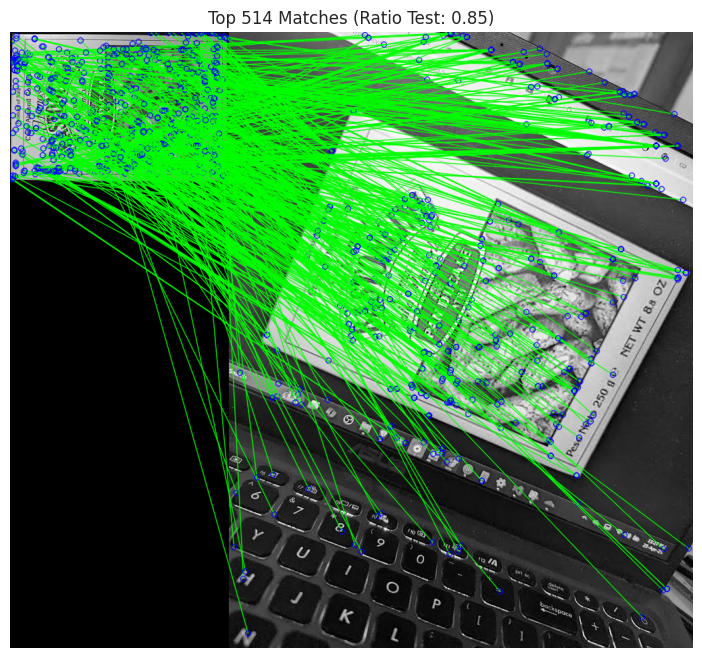

In [22]:
thresh = 0.85
matches = match_features(descriptors1, descriptors2,threshold=thresh)
draw_matches(img1, oriented_kp1, img2, oriented_kp2, matches,threshold=thresh)

> **Note :** You might notice a few false matches because SIFT descriptors, while robust, can still produce mismatches under certain conditions. Factors such as significant changes in scale, rotation, or viewpoint between the two images can lead to keypoints that appear similar but are not actually corresponding. Additionally, if the images contain repetitive textures or strong symmetry, it can confuse the descriptor matching process, causing incorrect matches to be identified. These false matches are typically less frequent with a properly tuned ratio test, but they can still occur, especially in complex scenes or with low-contrast features.

# ALL together

In [23]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png -O test_image.png # template
!gdown 1KfANIcWjnIp060TFPgLA_ZykXSNCBzM3 -O match.png #to match

--2025-04-27 09:33:00--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/box.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50728 (50K) [image/png]
Saving to: ‘test_image.png’

test_image.png      100%[===================>]  49.54K  --.-KB/s    in 0.05s   

2025-04-27 09:33:01 (1.01 MB/s) - ‘test_image.png’ saved [50728/50728]

Downloading...
From: https://drive.google.com/uc?id=1KfANIcWjnIp060TFPgLA_ZykXSNCBzM3
To: /content/match.png
100% 122k/122k [00:00<00:00, 113MB/s]


<ipython-input-4-8ca92737462e>:18: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  octave_images.append(filters.gaussian_filter(prev_img, sigma_total))
<ipython-input-14-b832390230bf>:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  gaussian = filters.gaussian_filter(img, sigma)
<ipython-input-14-b832390230bf>:6: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = filters.sobel(gaussian, 1)  # x gradient
<ipython-input-14-b832390230bf>:7: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = f

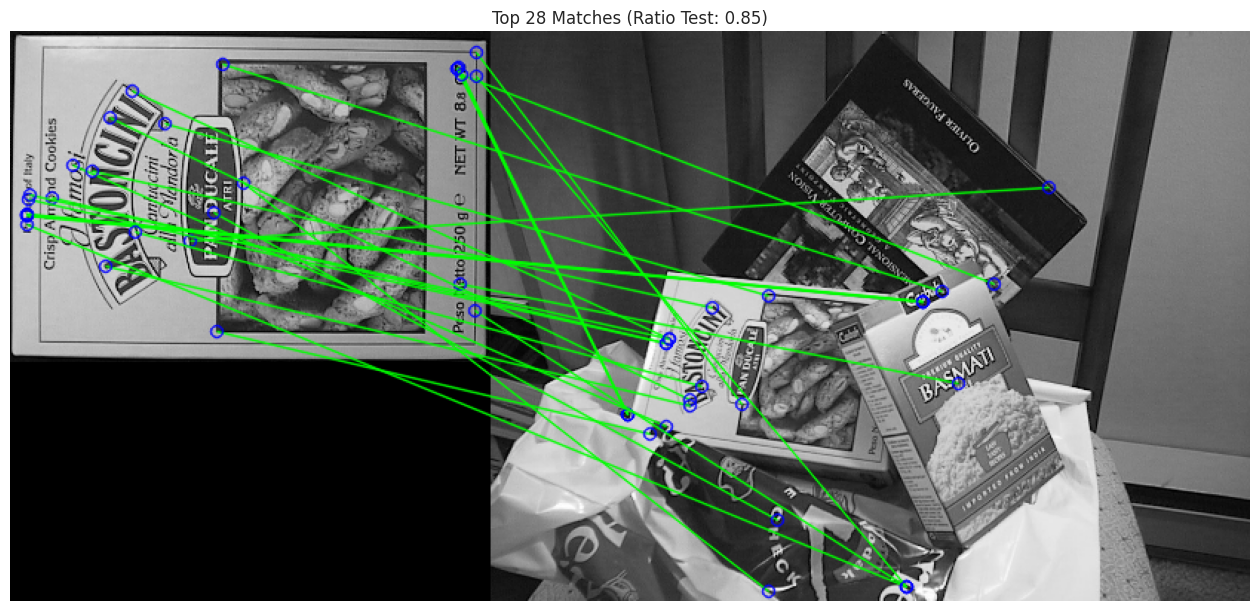

In [24]:
img1 = cv2.imread('test_image.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
img2 = cv2.imread('match.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)


num_octaves = 8
scales_per_octave = 3
initial_sigma = 1.6

octaves1 = generate_octaves(img1, num_octaves, scales_per_octave, initial_sigma)
octaves2 = generate_octaves(img2, num_octaves, scales_per_octave, initial_sigma)


dog_octaves1 = generate_dog(octaves1)
dog_octaves2 = generate_dog(octaves2)


keypoints1 = find_keypoints(dog_octaves1, max_keypoints=1000)
keypoints2 = find_keypoints(dog_octaves2, max_keypoints=1000)


img1_kp = draw_keypoints(img1, keypoints1)
img2_kp = draw_keypoints(img2, keypoints2)


oriented_kp1 = assign_orientations(img1, keypoints1)
oriented_kp2 = assign_orientations(img2, keypoints2)


descriptors1 = generate_descriptors(img1, oriented_kp1)
descriptors2 = generate_descriptors(img2, oriented_kp2)

thresh = 0.85
matches = match_features(descriptors1, descriptors2, threshold=thresh)
draw_matches(img1, oriented_kp1, img2, oriented_kp2, matches, threshold=thresh)